# Data Prep

This notebook is used to do EDA on the image metadata.  

The goal is to produce a Python class or py file that can be used to load and clean the data along with presisting any intermediate results. The produced class/file will be saved as CheXpertDataSetPrep.py.

By doing the initial work in this notebook, it will allow for better comments as well as show the decisions and attempts that was used to build the data prep object.

This notebook will mostly be left in it's raw form without cleanup, but the class file should be built with clean reusuable code.

In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

from datetime import datetime
from IPython.display import display

import os, os.path
from skimage import io
import copy

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary

%matplotlib inline

### Make sure we can read an image

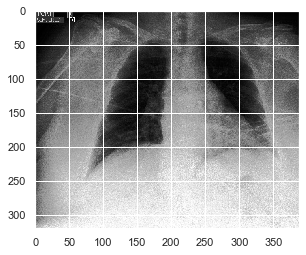

In [3]:
img = io.imread(os.path.join(root_path, "data/raw/train/patient00001/study1/view1_frontal.jpg"), as_gray=False)
imgplot = plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
def extended_describe(df):
    de = df.describe()

    nu = pd.DataFrame(df.nunique())
    nu.columns = ['nunique']
    nu = nu.transpose()

    nan = pd.DataFrame(df.isnull().sum(axis=0))
    nan.columns = ['nan']
    nan = nan.transpose()

    de = de.append([nu, nan], sort=False).transpose()
    de['categorical'] = de['count'].isnull()
    de.index.name = 'column'
    return de

In [5]:
# load CheXpert Image metadata
# Though CheXpert gave use a validation set with it's own metadata, there were too few images to be useful
# So we are only going to use the training images and split this into train and val/test

# drive.mount('/content/drive')


train_impage_path = root_path + "data/raw/train/"
train_csv = root_path + "data/raw/train.csv"

df = pd.read_csv(train_csv)

# Rename columns to be more Python friendly
df = df.rename(columns={'Frontal/Lateral': 'View', 
                        'AP/PA': 'Orientation',
                        'No Finding':'No_Finding',
                        'Enlarged Cardiomediastinum':'Enlarged_Cardiomediastinum',
                        'Lung Opacity':'Lung_Opacity',
                        'Lung Lesion':'Lung_Lesion',
                        'Pleural Effusion':'Pleural_Effusion',
                        'Pleural Other':'Pleural_Other',
                        'Support Device':'Support_Devices'})

# Make sure the path prefix is consistent before apply parsing logic
path_prefix = 'CheXpert-v1.0-small/train/'
patient_prefix = path_prefix + 'patient'
paths_with_different_prefix = df[~df.Path.str.contains(patient_prefix)].shape[0]
print(f'Number of rows with a different prefix = {paths_with_different_prefix}')
if paths_with_different_prefix > 0:
  raise Exception("Path prefix is not consistent, please update parsing logic") 

# Parse path to get PatientID
path_start_index_patient = len(patient_prefix)
path_end_index_patient = path_start_index_patient + 5 # Patient ID is fixed width of size 5
df['PatientID'] = df.Path.str.slice(path_start_index_patient,path_end_index_patient).astype(int)

# Parse path to get StudyID (Count of x-ray sessions for a single patient)
path_start_index_study = path_end_index_patient + 1 # Start off with end of PartientID + '/'
path_end_index_patient = path_start_index_study + len('studyxx') # Here we assume the studyID will only be 2 digits
df['StudyID'] = df.Path.str.slice(path_start_index_study,path_end_index_patient) \
                                    .str.replace('study', '') \
                                    .str.replace('/', '').astype(int)

# Add image path with proper relative URI
df['Image_Path'] = df.Path.str.replace(path_prefix, train_impage_path)
test_image_path = df.iloc[0]['Image_Path']
print('Sample Image Path: ', test_image_path)

df.index.names = ['ImageID']

df

Number of rows with a different prefix = 0
Sample Image Path:  C:/git/Springboard-Public/Capstone Project 2/data/raw/train/patient00001/study1/view1_frontal.jpg


,Path,Sex,Age,View,Orientation,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support Devices,PatientID,StudyID,Image_Path
ImageID,,,,,,,,,,,,,,,,,,,,,
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1,1,C:/git/Springboard-Public/Capstone Project 2/d...
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,2,2,C:/git/Springboard-Public/Capstone Project 2/d...
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,1,C:/git/Springboard-Public/Capstone Project 2/d...
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2,1,C:/git/Springboard-Public/Capstone Project 2/d...
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3,1,C:/git/Springboard-Public/Capstone Project 2/d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,64537,2,C:/git/Springboard-Public/Capstone Project 2/d...
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,64537,1,C:/git/Springboard-Public/Capstone Project 2/d...
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64538,1,C:/git/Springboard-Public/Capstone Project 2/d...


### Reducing the Dataset

There could be several approaches here including running the model on all images in the original dataset.

But since the main goal of this project is to explore the effectiveness of different models, removing some of the more complex aspects of the dataset should make comparing the different models easier.  Depending on how the project goes, this reduction can be removed, but will at least start in this direction.

There are 2 aspects to this reduction.  The first is to only use frontal views.  Lateral views are very helpful in making some of the diagnoses, but add complexity to the training process.  Almost all chest x-ray studies do a frontal view while only some add a lateral view.  So just using frontal makes sense.  The view (Frontal/Lateral) and the Orientation (AP/PA) are not independent features.  In fact, AP (Anterior to Posterior) and PA (Posterior to Anterior) are only for Frontal views.  Lateral views might not include the Orientation or be marked as Left to Right or vice versa.  So we need to make sure the Frontal views only have PA or AP Orientations.

The second aspect of this reduction is help overfitting on overrepresented patients.  The same patient can have multiple x-rays in this dataset in 2 ways, multiple views and multiple studies.  At least 1 patient has over 90 studies.  Some of the diagnoses can change between studies like pneumonia, but some tend to be persistent like cardiomegaly.

The overrepresentation of patients may produce leaks, i.e. the shape of the xiphoid process might be used as a feature for cardiomegaly if the same patient with cardiomegaly is trained over 100 times.

#### Refractory Leaks
There might be leaks inherent to the nature of the films that can't be dealt with.  Patients who are hospitalized have a greater chance of having more findings.  But artifacts of being in a hospital can show up in the film.  This include EKG pads, IVs, gown snaps.  Higher acuity patients may have their x-rays done while they are lying in their beds.  These tend to be AP orientations.  Training will undoubtedly find features of these inpatient studies and leak some results.  



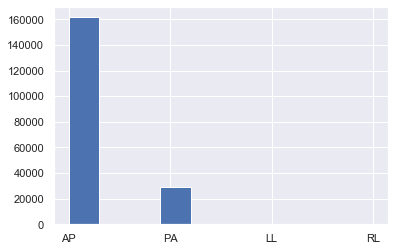

In [6]:
df.Orientation.hist()

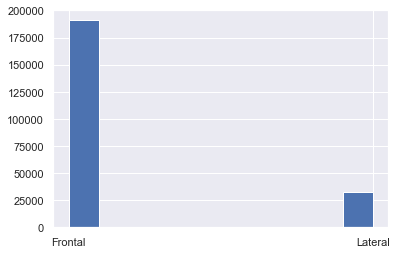

In [7]:
df.View.hist()

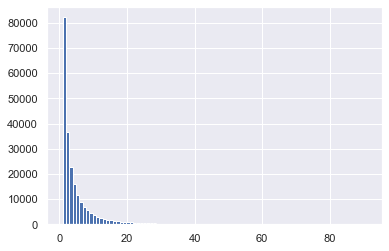

In [8]:
df.StudyID.hist(bins=91)

In [9]:
df_reduced = df[
                (df.View == 'Frontal') & # Don't show x-rays from the side
                (df.StudyID < 5) & # Don't include more than 4 studies for a single patient
                ((df.Orientation == 'AP') | (df.Orientation == 'PA')) # Don't show Left or Right Lateral
                ]


print(f'Number of x-rays removed = {df.shape[0] - df_reduced.shape[0]:,}')
extended_describe(df_reduced)

Number of x-rays removed = 91,666


,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
Age,131748.0,61.014239,18.208082,0.0,49.0,63.0,75.0,90.0,74.0,0.0,False
No_Finding,15024.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,116724.0,False
Enlarged_Cardiomediastinum,27199.0,0.004412,0.703365,-1.0,0.0,0.0,0.0,1.0,3.0,104549.0,False
Cardiomegaly,26402.0,0.378683,0.776192,-1.0,0.0,1.0,1.0,1.0,3.0,105346.0,False
Lung_Opacity,67223.0,0.842777,0.477567,-1.0,1.0,1.0,1.0,1.0,3.0,64525.0,False
Lung_Lesion,7210.0,0.637725,0.702110,-1.0,1.0,1.0,1.0,1.0,3.0,124538.0,False
Edema,51350.0,0.435365,0.750327,-1.0,0.0,1.0,1.0,1.0,3.0,80398.0,False
Consolidation,41727.0,-0.208306,0.738026,-1.0,-1.0,0.0,0.0,1.0,3.0,90021.0,False
Pneumonia,16362.0,-0.474086,0.823732,-1.0,-1.0,-1.0,0.0,1.0,3.0,115386.0,False


In [10]:
# The only columns with null values are the targets
# -1 = negative finding (the patient does NOT have this finding)
#  1 = positive finding (the patient HAS this finding)
#  0 = no position on the finding
# So it should be safe to change all the nan in the df to 0 (no position)
df_clean = df_reduced.fillna(0, inplace=False)

# We already extracted all the information we needed from path and view, so we can drop these columns
df_clean.drop(['Path', 'View'], axis=1, inplace=True)

# This leaves us with just 2 categorical columns
# So lest hot-one enode these
df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Orientation'], drop_first=True)
# Sex: Not Male or Unknown = Female
# Orientation: Not PA = AP

# Let's clean up the column order with features first
feature_columns = ['PatientID',
                    'StudyID',
                    'Age',
                    'Sex_Male',
                    'Sex_Unknown',
                    'Orientation_PA']
meta_columns = ['Image_Path']
target_columns = ['No_Finding',
                    'Enlarged_Cardiomediastinum',
                    'Cardiomegaly',
                    'Lung_Opacity',
                    'Lung_Lesion',
                    'Edema',
                    'Consolidation',
                    'Pneumonia',
                    'Atelectasis',
                    'Pneumothorax',
                    'Pleural_Effusion',
                    'Pleural_Other',
                    'Fracture',
                    'Support Devices'
                   ]
df_clean = df_clean[feature_columns + meta_columns + target_columns]

for c in target_columns:
    df_clean[c] = df_clean[c].astype('int8')

extended_describe(df_clean)

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
PatientID,131748.0,30663.818350,17430.703024,1.0,15763.0,31366.0,44385.0,64540.0,64534.0,0.0,False
StudyID,131748.0,1.866700,1.031453,1.0,1.0,1.0,3.0,4.0,4.0,0.0,False
Age,131748.0,61.014239,18.208082,0.0,49.0,63.0,75.0,90.0,74.0,0.0,False
Sex_Male,131748.0,0.571447,0.494871,0.0,0.0,1.0,1.0,1.0,2.0,0.0,False
Sex_Unknown,131748.0,0.000008,0.002755,0.0,0.0,0.0,0.0,1.0,2.0,0.0,False
Orientation_PA,131748.0,0.179046,0.383393,0.0,0.0,0.0,0.0,1.0,2.0,0.0,False
No_Finding,131748.0,0.114036,0.317856,0.0,0.0,0.0,0.0,1.0,2.0,0.0,False
Enlarged_Cardiomediastinum,131748.0,0.000911,0.319585,-1.0,0.0,0.0,0.0,1.0,3.0,0.0,False
Cardiomegaly,131748.0,0.075887,0.379090,-1.0,0.0,0.0,0.0,1.0,3.0,0.0,False


### So now we have to decide what we are going to do with the targets

####  First, there are n targets, but the targets are not independant
- I can have both Cardiomegaly and Pneumonia
- A pneumothorax (or even pneumonia) can be caused from rib fractures

- **We will look at the "covariance" between the n targets to get a better feel of the dependency**

#### Second, each target can have 3 values, Negative, no finding and Positive

#### Third, some of the targets may not be targets
- No Finding is a lack of any positive targets
- Support Devices might be considered more of a

### We need to think of the end of our model
- Size of out last Fully Connected Layer?
- How will the SoftMax work?

### Cartesian Product
- Remove No Finding
- Make Support Device a Feature (will we be using features in our model. i.e. some kind of ensumable?)
- This gives us 12 targets, each with 3 possible values
- $3^{12} = 531,441$ targets, that's close to $1/2$ million categories to predict
- What if we make the targets Boolean, Positive or Not Positive
- $2^{12} = 4,096$ targets, that's much better, but still a lot of classes


### Let's look at target independancy


In [11]:
# Remove No Finding and move Support Devices to the feature columns
feature_columns = ['PatientID',
                    'StudyID',
                    'Age',
                    'Sex_Male',
                    'Sex_Unknown',
                    'Orientation_PA',
                    'Support Devices']
meta_columns = ['Image_Path']
target_columns = ['Enlarged_Cardiomediastinum',
                    'Cardiomegaly',
                    'Lung_Opacity',
                    'Lung_Lesion',
                    'Edema',
                    'Consolidation',
                    'Pneumonia',
                    'Atelectasis',
                    'Pneumothorax',
                    'Pleural_Effusion',
                    'Pleural_Other',
                    'Fracture'
                   ]
df_clean = df_clean[feature_columns + meta_columns + target_columns]
print(f'Target Count = {len(target_columns)}')

Target Count = 12


In [12]:
total_rows = df_clean.shape[0]
df_combined = pd.DataFrame(df_clean.PatientID)
df_combined['Combined_Targets'] = ''
for c in target_columns:
    df_combined['Combined_Targets'] = df_combined['Combined_Targets'] + df_clean[c].map({-1:'N', 0:'0', 1:'P'})
   
g = pd.DataFrame(df_combined.groupby(['Combined_Targets']).count())
g.columns = ['Combined_Target_count']
g['Percent'] = g.Combined_Target_count / total_rows
print(f'Total Unique Target Combinations {g.shape[0]:,}')
g = g.sort_values(['Combined_Target_count'], ascending=False)
g.head(10)

Total Unique Target Combinations 5,384


,Combined_Target_count,Percent
Combined_Targets,,
000000000000,18717,0.142067
00P000000P00,5177,0.039295
0000P0000000,3570,0.027097
000000000P00,3080,0.023378
00P000000000,3013,0.022869
00P0P0000P00,2753,0.020896
00000000P000,2620,0.019886
0000000P0000,2308,0.017518
00P00N0N0000,2258,0.017139


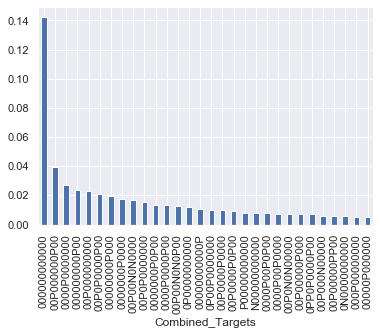

In [13]:
g.head(30).Percent.plot.bar()

### 5,384 Unique Findings

So there is no way to find a simple single label approach.

#### Multi-Label Classificaiton
We will spend the time to do true multi-Label classsification.  Since we have 12 targets, we will have to add 12 outputs to our forward model.  This adds complexity, but it doesn't look like there will be good alternatives other then just trying to predict a single label like pneumonia.

We also want to keep the tri-state for each class.  A negative finding is very different than no finding given.

So the bottom line is that we save some complexity with our reduction, but add complexity with multi-label.

In [14]:
df_clean

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,,,,,,,,,
0,1,1,68,0,0,0,1,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2,87,0,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,-1,1,0,-1,-1,0,-1,0,-1,0,1
2,2,1,83,0,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,1,0,0,-1,0,0,0,0,0,1
4,3,1,41,1,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,0,0,1,0,0,0,0,0,0,0
5,4,1,20,0,0,1,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,64537,2,59,1,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,-1,0,0,0,0,-1,0,1,0,0
223410,64537,1,59,1,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,-1,0,0,0,0,-1,0,-1,0,0
223411,64538,1,0,0,0,0,0,C:/git/Springboard-Public/Capstone Project 2/d...,0,0,0,0,-1,0,0,0,0,0,0,0


## Test CheXpert.CleanMetaData class

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,,,,,,,,,
0,1,1,68,0,0,0,1.0,data/raw/train/patient00001/study1/view1_front...,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2,87,0,0,0,0.0,data/raw/train/patient00002/study2/view1_front...,0,-1,1,0,-1,-1,0,-1,0,-1,0,1
2,2,1,83,0,0,0,0.0,data/raw/train/patient00002/study1/view1_front...,0,0,1,0,0,-1,0,0,0,0,0,1
4,3,1,41,1,0,0,0.0,data/raw/train/patient00003/study1/view1_front...,0,0,0,0,1,0,0,0,0,0,0,0
5,4,1,20,0,0,1,0.0,data/raw/train/patient00004/study1/view1_front...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,64537,2,59,1,0,0,0.0,data/raw/train/patient64537/study2/view1_front...,0,0,-1,0,0,0,0,-1,0,1,0,0
223410,64537,1,59,1,0,0,0.0,data/raw/train/patient64537/study1/view1_front...,0,0,-1,0,0,0,0,-1,0,-1,0,0
223411,64538,1,0,0,0,0,0.0,data/raw/train/patient64538/study1/view1_front...,0,0,0,0,-1,0,0,0,0,0,0,0


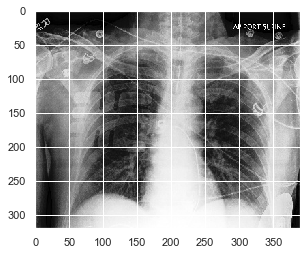

data/raw/train/


In [15]:
from modules.lib.ChextXRayImages import CleanMetaData
metaData = CleanMetaData()
cdf = metaData.getCleanDF()
display(cdf)
img = metaData.displayImage(123)
imgplot = plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()
print(metaData.imageFolderPath())

In [16]:
cdf = metaData.getCleanDF(n_random_rows=500)
display(cdf)

,PatientID,StudyID,Age,Sex_Male,Sex_Unknown,Orientation_PA,Support Devices,Image_Path,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture
ImageID,,,,,,,,,,,,,,,,,,,,
98735,23799,3,54,0,0,0,1.0,data/raw/train/patient23799/study3/view1_front...,0,0,0,0,1,0,0,1,0,0,0,0
216398,59058,1,25,1,0,0,0.0,data/raw/train/patient59058/study1/view1_front...,0,0,0,0,0,0,0,0,0,0,0,1
32290,7897,3,90,1,0,0,0.0,data/raw/train/patient07897/study3/view1_front...,0,0,0,0,1,0,0,0,0,1,0,0
198595,48952,1,18,1,0,0,1.0,data/raw/train/patient48952/study1/view1_front...,0,0,0,0,0,0,0,0,1,0,0,0
124396,29782,4,57,0,0,0,1.0,data/raw/train/patient29782/study4/view1_front...,0,1,1,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142481,34248,2,77,0,0,0,1.0,data/raw/train/patient34248/study2/view1_front...,0,-1,0,0,0,0,0,0,0,0,0,0
57070,13824,3,50,0,0,0,0.0,data/raw/train/patient13824/study3/view1_front...,0,0,1,0,0,-1,0,0,0,0,0,0
149525,35472,3,90,0,0,0,1.0,data/raw/train/patient35472/study3/view1_front...,1,0,1,0,1,0,0,0,0,0,0,0
